# Data Gathering

Two independent data sources are used in the modeling process. The first is a dataset of vacant and abandoned buildings, defined by tax parcel area, in the form of an [ESRI shapefile](training_data/abandoned_and_vacant/) ([Data Source](https://data.indy.gov/datasets/abandoned-and-vacant-housing?geometry=-86.313%2C39.748%2C-85.983%2C39.794)). The second dataset is a [LiDAR satellite imagery tile](training_data/las_files), in the file format .las ([Data Source](https://lidar.jinha.org/download.php?cname=marion&clon=-86.13305839196093&clat=39.779844384833936&years=2011,2016)). Certain steps are necessary to align the two datasets in the same spacial coordinate system.

The desired coordinate reference system (CRS) for both datasets is standard latitude longitude, whish is abbreviated by the EPSG code 4326. The vacant and abandoned buildings data is already in CRS 4326, however the LiDAR data is in an alternative CRS, represented by the code 102673. The LiDAR data is transformed to 4326 and finally aligned with the vacant and abandoned buildings data, as seen in the final image at the bottom of this notebook.

In [56]:
import geopandas as gp
import os
import numpy as np
from laspy.file import File
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pickle

## Data sources

In [39]:
# Find SRC codes here: https://spatialreference.org/
# SRC code for lidar found here: https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html#/
# Another SRC code for lidar: https://epsg.io/102673
# INDIANA EAST ZONE FIPSZONE: 1301 ADSZONE: 3826 UTM ZONE: 16
# CONVERSION TOOL: https://www.ngs.noaa.gov/NCAT/

# LiDAR metadata soure: https://www.dropbox.com/sh/ft35dwy9m5qe9f1/AACXW_W_DoWDiHeOUh00tAzja/2016%20Marion%20County?dl=0&subfolder_nav_tracking=1

url_lidar = 'https://lidar.jinha.org/download.php?cname=marion&clon=-86.13305839196093&clat=39.779844384833936&years=2011,2016'
url_vacant_and_abandoned_dataset = 'https://data.indy.gov/datasets/abandoned-and-vacant-housing?geometry=-86.313%2C39.748%2C-85.983%2C39.794'

In [40]:
# CRS code for the input .las files
crs_input = 'ESRI:102673'

# Desired format
crs_lat_lon = 'EPSG:4326'

## Load geo-data on abandoned and vacant buildings

In [41]:
# Abandoned building data is stored here
base_path = './training_data/abandoned_and_vacant/'

# Abandoned building shapefile
gdf_abandoned = gp.read_file(base_path + 'Abandoned_And_Vacant_Housing.shp', crs=crs_lat_lon)

print(gdf_abandoned.shape)
gdf_abandoned.head()

(7216, 15)


,OBJECTID,PARCEL_I,STNUMBER,PRE_DIR,STREET_NAM,SUFFIX,SUF_DIR,FULL_STNAM,CITY,ZIPCODE,ADDRESS,STATUS,SHAPEAREA,SHAPELEN,geometry
0,345944,1029867,2365,None,ADAMS,ST,None,ADAMS ST,INDIANAPOLIS,46218,2365 ADAMS ST,Abandoned,12801.863622,480.073502,"POLYGON ((-86.10858 39.80163, -86.10858 39.801..."
1,346056,1010458,2755,N,KEYSTONE,AVE,None,KEYSTONE AVE,INDIANAPOLIS,46218,2755 N KEYSTONE AVE,Abandoned,11133.172761,434.607365,"POLYGON ((-86.12098 39.80677, -86.12146 39.806..."
2,346078,1088338,1929,None,HOUSTON,ST,None,HOUSTON ST,INDIANAPOLIS,46218,1929 HOUSTON ST,Abandoned,5400.130625,350.010293,"POLYGON ((-86.10891 39.79337, -86.10891 39.793..."
3,346248,1024949,40,None,EASTERN,AVE,None,EASTERN AVE,INDIANAPOLIS,46201,40 EASTERN AVE,Abandoned,4999.768822,329.991105,"POLYGON ((-86.11771 39.76975, -86.11816 39.769..."
4,346265,1014955,1031,N,TACOMA,AVE,None,TACOMA AVE,INDIANAPOLIS,46201,1031 N TACOMA AVE,Abandoned,6405.338407,436.020670,"POLYGON ((-86.11886 39.78222, -86.11951 39.782..."


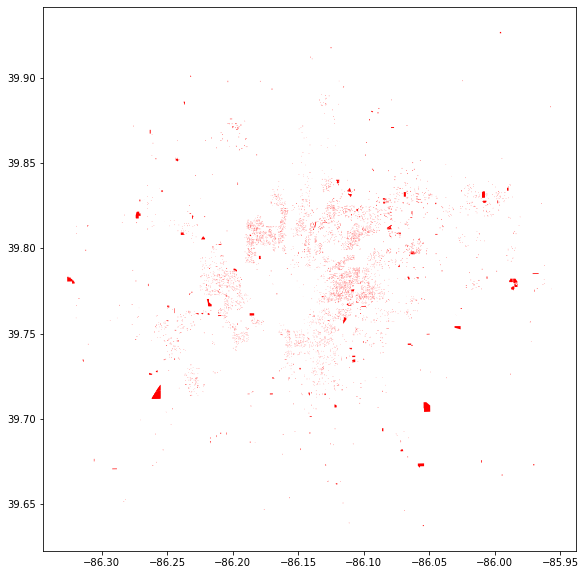

In [79]:
# Map the abandoned properties
f, ax = plt.subplots(figsize=(15,10))

gdf_abandoned.plot(ax=ax, color='red');

In [ ]:
# Filter for abandoned buildings within the satellite image
x_abandoned = gdf_abandoned['geometry'].representative_point().x
y_abandoned = gdf_abandoned['geometry'].representative_point().y

x_valid = (x_abandoned > x_min) & (x_abandoned < x_max)
y_valid = (y_abandoned > y_min) & (y_abandoned < y_max)

gdf_abandoned_filtered = gdf_abandoned.loc[x_valid & y_valid, :].copy()

## Load the lidar data for Indianapolis, IN

In [62]:
def las_to_geodf(filename, crs=None):
    '''Convert an .las file to a Geopandas Geodataframe object.'''

    print('Trying file', filename, '\n')
    usft_to_meter = 0.30480060960121924
    base_path = './training_data/las_files/'

    #Read LAS file
    try:
        inFile = File(base_path + filename)
        print('inFile accepted.')
    except:
        print(filename, " failed.")
        return None

    #Import LAS into numpy array
    lidar_points = np.array((inFile.x*usft_to_meter,
                             inFile.y*usft_to_meter,
                             inFile.z*usft_to_meter,
                             inFile.intensity,
                             inFile.classification)).transpose()
    print('information accepted.')

    #Transform to geopandas GeoDataFrame
    lidar_geodf = gp.GeoDataFrame(lidar_points, geometry = gp.points_from_xy(inFile.x, inFile.y), crs=crs)
    lidar_geodf.rename(columns = {0:'x', 1:'y', 2:'z', 3:'intensity', 4:'classification'}, inplace=True)
    print('points accepted.')

    print(filename, " successful.\n")
    inFile.close()

    return lidar_geodf

In [ ]:
# Lidar satellite data
las_files = [f for f in os.listdir('./training_data/las_files/') if f[0]!='.']

las_file = las_files[0]
las_file

In [27]:
gdf = las_to_geodf(las_file, crs=crs_input)
gdf

Trying file MC_01951645.las 

inFile accepted.
information accepted.
points accepted.
MC_01951645.las  successful.



,x,y,z,intensity,classification,geometry
0,60350.502413,502919.957328,227.442215,9216.0,1.0,POINT (197999.940 1649996.560)
1,60349.307595,502920.880874,227.518415,11264.0,1.0,POINT (197996.020 1649999.590)
2,60349.386843,502919.835408,227.454407,7424.0,1.0,POINT (197996.280 1649996.160)
3,60349.469139,502918.786894,227.426975,8704.0,2.0,POINT (197996.550 1649992.720)
4,60349.816612,502920.192024,238.101092,3584.0,1.0,POINT (197997.690 1649997.330)
...,...,...,...,...,...,...
11299799,60359.372111,502920.917450,235.046990,15104.0,1.0,POINT (198029.040 1649999.710)
11299800,60357.409195,502920.963170,227.539751,8448.0,1.0,POINT (198022.600 1649999.860)
11299801,60355.019558,502920.883922,239.369063,2560.0,1.0,POINT (198014.760 1649999.600)
11299802,60353.724155,502920.990602,240.423673,1536.0,1.0,POINT (198010.510 1649999.950)


In [28]:
gdf_4326 = gdf.loc[:, ['intensity', 'z', 'geometry']].to_crs(crs_lat_lon)
gdf_4326

,intensity,geometry
0,9216.0,POINT (-86.12949 39.77753)
1,11264.0,POINT (-86.12951 39.77754)
2,7424.0,POINT (-86.12951 39.77753)
3,8704.0,POINT (-86.12950 39.77752)
4,3584.0,POINT (-86.12950 39.77754)
...,...,...
11299799,15104.0,POINT (-86.12939 39.77754)
11299800,8448.0,POINT (-86.12941 39.77754)
11299801,2560.0,POINT (-86.12944 39.77754)
11299802,1536.0,POINT (-86.12945 39.77754)


In [ ]:
# Pickle the LiDAR GeoDataFrame
filename = 'las_file_geodf'
with open(filename, 'w+b') as outfile:
    pickle.dump(gdf_4326, outfile)

## Visualize

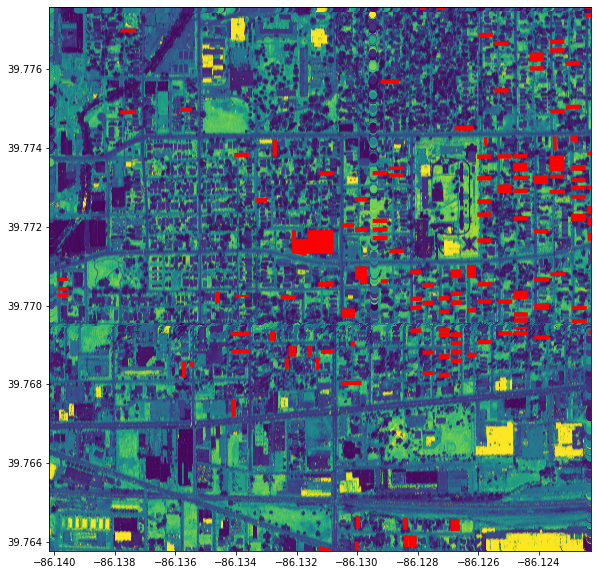

In [82]:
# Map the abandoned properties over the satelite image

# Boundaries for the LiDAR tile
x_min, x_max, y_min, y_max = -86.14016495696444, -86.12228581315563, 39.76377561875412, 39.777572323113745

# Plotting
f, ax = plt.subplots(figsize=(15,10))

gdf_4326.plot('intensity', ax=ax)
gdf_abandoned.plot(ax=ax, color='red')
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max);

**Interpretaion:** The red blocks represent vacant buildings. Since the two datasets come from different sources, and particularly becasue they originated in different coordinate reference systems, we must check visually that they line up well. The above image is reassuring; there are no obvious signs of distortion such as red parcels overlying streets.